In [1]:
import torch
from torchvision.transforms import ToTensor, RandomAffine

from data import combine_transforms, load_data, OneHot
from train_model import initialize_model, train_model, evaluate_model

import numpy as np

In [2]:
image_shape = (3, 32, 32)

use_gpu = True

n_epochs = 10
batch_size = 128

rec_criterion = torch.nn.BCELoss()

In [3]:
prep = []
aug = [RandomAffine(30)]
postp = [ToTensor()]
target = []

train_transform, test_transform, target_transform = combine_transforms(preprocessing=prep, 
                                                                        augmentations=aug, 
                                                                        postprocessing=postp, 
                                                                        target=target)

In [4]:
train_loader, test_loader = load_data('../data', 
                                      train_transform, test_transform, target_transform, 
                                      batch_size, use_gpu)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = initialize_model(
    n_latent_features=64, 
    use_gpu=use_gpu
)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [6]:
train_model(
    model, 
    rec_criterion,
    optimizer,
    train_loader, 
    n_epochs
)

epoch #0 mean train loss: 0.552
epoch #1 mean train loss: 0.533
epoch #2 mean train loss: 0.530
epoch #3 mean train loss: 0.528
epoch #4 mean train loss: 0.526
epoch #5 mean train loss: 0.525
epoch #6 mean train loss: 0.524
epoch #7 mean train loss: 0.524
epoch #8 mean train loss: 0.523
epoch #9 mean train loss: 0.523


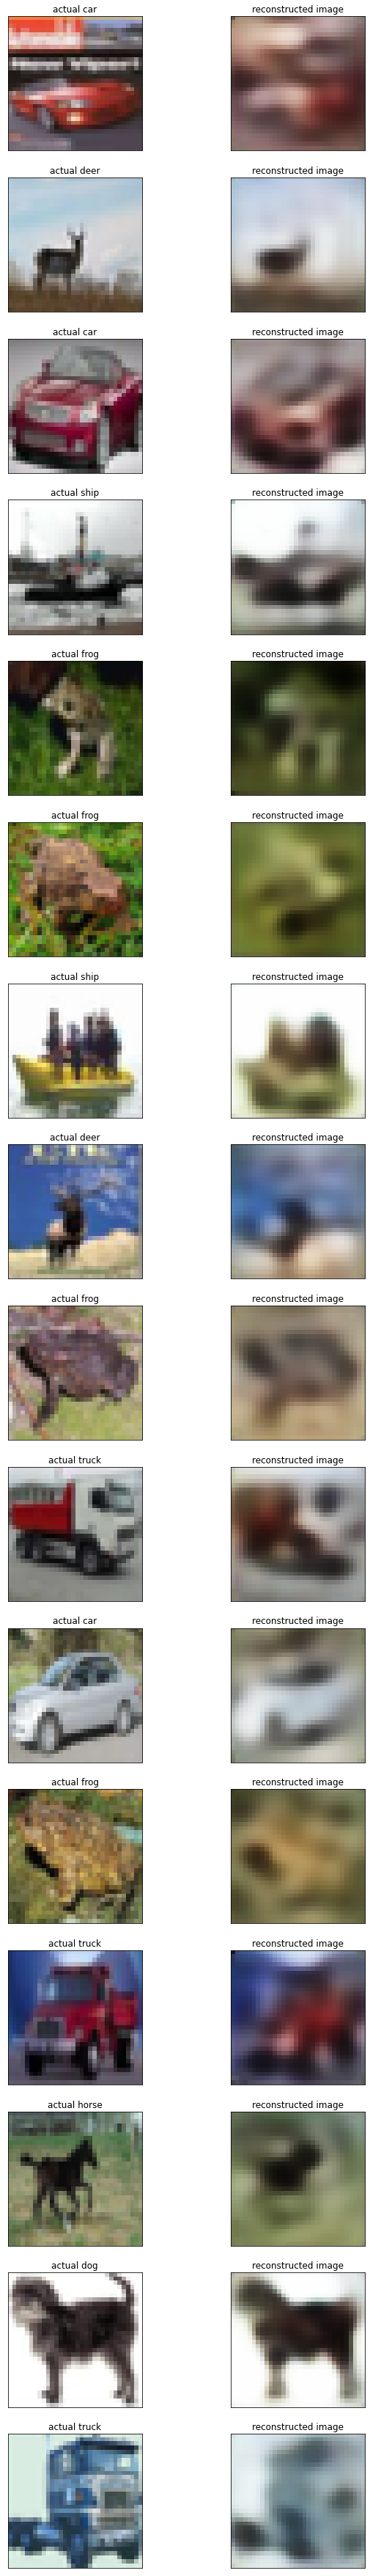

In [7]:
model.eval();
evaluate_model(model, test_loader)